In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm
from itertools import groupby
import networkx as nx
import collections
from importlib import reload

# local modules (the classes Lattice, BS)
from src import lattice
from src.lattice import *
from src import bs
from src.bs import *

In [2]:
%matplotlib notebook

# Reload classes

In [3]:
reload(bs)
reload(lattice);
from src.bs import *
from src.lattice import *

# Helper function

In [4]:
def plt_color(i):
    """Return MatPlotLib default color from cycle at the provided index"""
    
    colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    return colors[np.array(i) % len(colors)]

# Experiments

In [5]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=0.01, fitness_correlation=0, migration_bias=0)
%time l.run(1000, collect_data=True)

CPU times: user 14.4 s, sys: 73.1 ms, total: 14.5 s
Wall time: 14.5 s


### Area curve

<IPython.core.display.Javascript object>


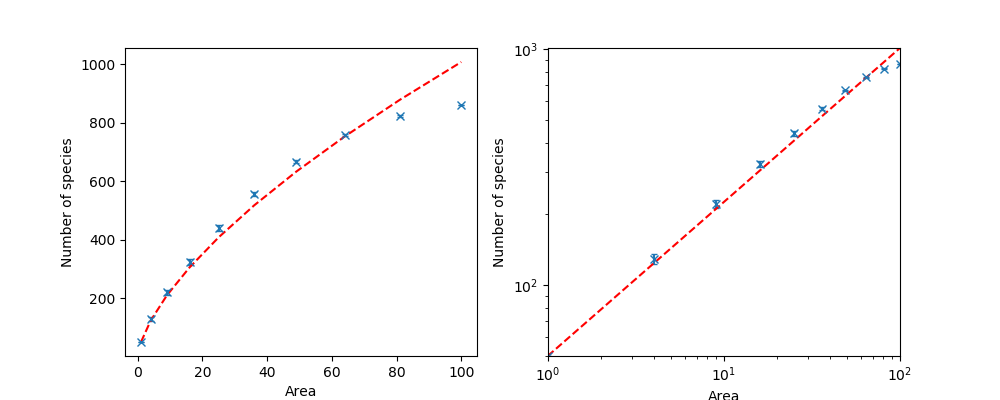

power: 0.652, MSE: 0.009188367259047509
power: 0.652, MSE: 0.009188367259047509


(0.6522108106197718, 0.009188367259047509)

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
l.area_curve(ax=ax1, log=False)
l.area_curve(ax=ax2, log=True)

### Avalanches

<IPython.core.display.Javascript object>


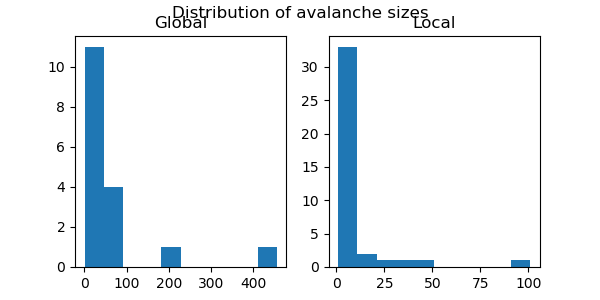

Text(0.5, 0.98, 'Distribution of avalanche sizes')

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.set_title('Global')
ax1.hist(l.av.trace[1:], bins=10)
ax2.set_title('Local') # sample size = 1
ax2.hist(l.av_local.trace[1:], bins=10)
plt.suptitle("Distribution of avalanche sizes")

### Species spreading over lattice

<IPython.core.display.Javascript object>


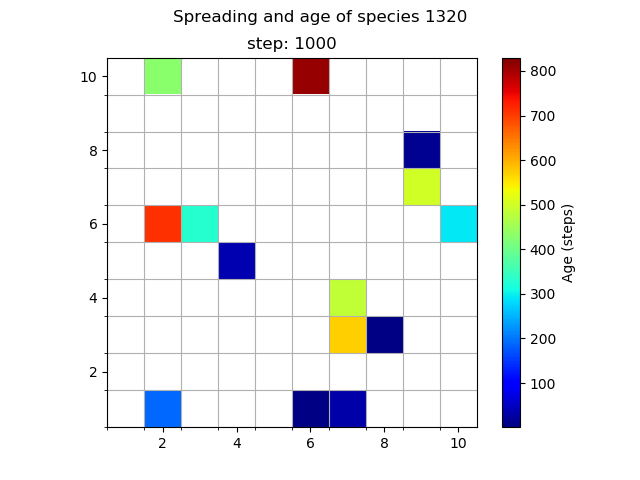

In [9]:
# create colormap
cmap = matplotlib.cm.get_cmap("jet")
cmap.set_under("white")

# count the most common species
species_count = collections.Counter([x for l in l.data.flatten() for x in l])
spec_id, _ = species_count.most_common(1)[0]

# get the maximum age of the selected species
max_age = 0
for i,j in l.lattice:
    a = l.data[:, i,j]
    present = [spec_id in x for x in a]
    oldest = max(sum(1 if i else 0 for i in g) for k,g in groupby(present))
    max_age = max(max_age, oldest)

# initialise the plot
fig, ax = plt.subplots()
fig.suptitle("Spreading and age of species {}".format(spec_id))
im_data = np.zeros(l.dimensions)
im = ax.imshow(im_data, cmap=cmap, vmin=1, vmax=max_age,
               extent=(0.5, l.dimensions[0]+0.5, 0.5, l.dimensions[1]+0.5))
ax.set_xticks(np.arange(l.dimensions[0])+0.5, minor=True)
ax.set_yticks(np.arange(l.dimensions[1])+0.5, minor=True)
ax.grid(True, which="minor")
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Age (steps)")

# animate function
step_size = 1
def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))
    
    for i,j in np.ndindex(l.dimensions):
        if spec_id in species[i,j]:
            im_data[i,j] += 1
        else:
            im_data[i,j] = 0
    im.set_data(im_data)
    
    return im

# start animation and optionally save as mp4
ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=1000/60, repeat=False, blit=True, save_count=2000)
# ani.save("migration_of_species_{}.mp4".format(spec_id))

### Habitat size distribution

CPU times: user 41.8 s, sys: 253 ms, total: 42 s
Wall time: 42.4 s
CPU times: user 28.5 s, sys: 195 ms, total: 28.7 s
Wall time: 28.9 s
CPU times: user 43.8 s, sys: 53.7 ms, total: 43.8 s
Wall time: 43.8 s


<IPython.core.display.Javascript object>


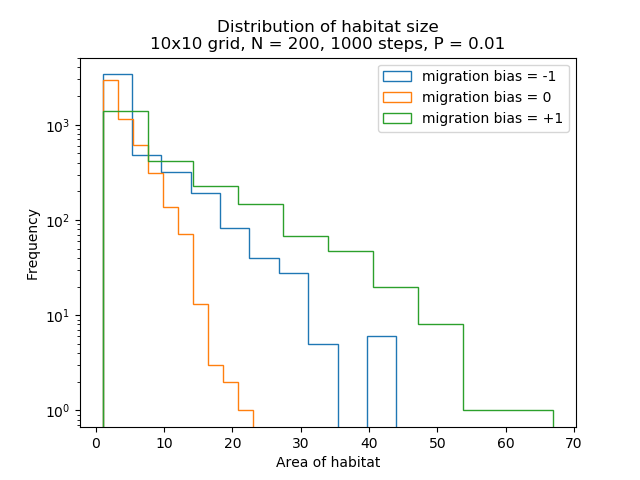

In [11]:
dimensions = (10,10)
N = 200
steps = 1000 
P = 0.01

migration_biases = [-1, 0, 1]

# run simulations for different migration biases
ls = np.empty(len(migration_biases), dtype=object)
for i, bias in enumerate(migration_biases):
    l = Lattice(dimensions, N=N, network=("watts-strogatz", 3, 0),
                P=P, fitness_correlation=0, migration_bias=bias)
    %time l.run(steps, collect_data=False)
    ls[i] = l

# plot the habitat size distributions
fig, ax = plt.subplots()
for i, bias in enumerate(migration_biases):
    species_count = collections.Counter([x for p in ls[i].lattice for x in ls[i][p].species_list])
    label = ("+" if bias > 0 else "") + str(bias)
    ax.hist(species_count.values(), bins=None, histtype="step", label="migration bias = {}".format(label))

ax.set_yscale("log")
ax.set_title("Distribution of habitat size\n{}x{} grid, N = {}, {} steps, P = {}".format(
    dimensions[0], dimensions[1], N, steps, P))
ax.set_xlabel("Area of habitat")
ax.set_ylabel("Frequency")
ax.legend()

### Mean number of species over time

<IPython.core.display.Javascript object>


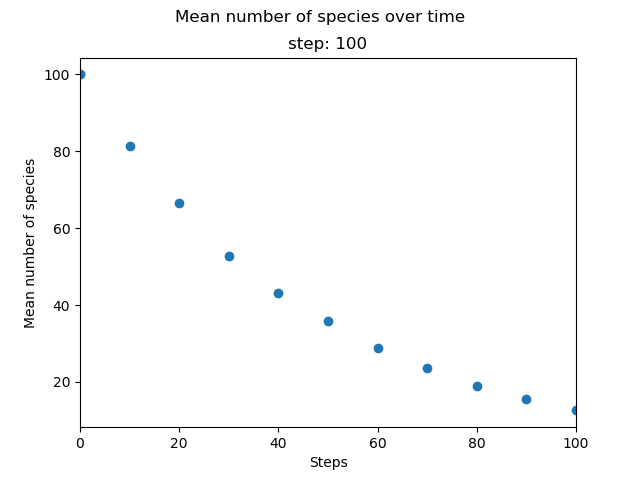

In [12]:
# init simulation
dimensions = (6,6)
l = Lattice(dimensions, 100, ("watts-strogatz", 3, 0), 1/3)
step_size = 10
steps = 10

# init plot
fig, ax = plt.subplots()
fig.suptitle("Mean number of species over time")
line, = plt.plot([],[], "o")
ax.set_xlim(0, steps*step_size)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean number of species")

# run simulation and animate
def animate(i):
    if i > 0:
        l.run(step_size)

    t = i * step_size
    
    ax.set_title("step: {}".format(t))
    line.set_xdata(np.append(line.get_data()[0], [t]))
    line.set_ydata(np.append(line.get_data()[1], [l.mean_species()]))
    
    ax.relim()
    ax.autoscale_view()
    
    return line

ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=500, repeat=False, blit=True, save_count=1000)

## Parameter sweeps